<center>

# Using Audio FX to alter music emotion

</center>

<center>

Stelios Katsis  
Dept. of Electrical and Computer Engineering  
National Technical University of Athens  
Athens, Greece  
el20139@mail.ntua.gr

<center>

In this notebook, we will study the impact of audio effects (FX) on music emotion recognition (MER). Specifically, we will evaluate datasets such as EMOPIA, RAVDESS, and DEAM, explore state-of-the-art models like MERT and analyze how FX influence emotional dimensions like arousal and valence. By comparing results from original and FX-modified music, we aim to uncover patterns and insights into the dynamic relationship between audio manipulation and emotional perception.  
The structure of this notebook will be of the following form:
1. Dataset Evalutation/Preprocessing
2. Model Evalutation
3. Apply Audio FX to Music
4. Input Modified Data into the Model
5. Result Analysis

Before we start, let's import the necessary libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install muspy pandas torch transformers datasets kagglehub librosa midi2audio pickle5 xgboost scikit-learn==1.0.2 optuna pedalboard seaborn

In [ ]:
!apt-get update
!apt-get install fluidsynth

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
from datasets import load_dataset, Dataset
import kagglehub
import librosa
import numpy as np
import optuna
import os
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch import nn
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from transformers import Wav2Vec2FeatureExtractor, AutoModel
from xgboost import XGBClassifier

### 1. Dataset Evalutation/Preprocessing

In this section we will try to explore the structure and labels of the datasets **EMOPIA**, **RAVDESS** and **DEAM**. After pointing out each dataset's advantages and weaknesses, we will make a decision about which data are going to be used in the later steps of the project

#### a. EMOPIA Dataset

We first have to download the dataset

In [ ]:
import muspy

emopia = muspy.EMOPIADataset("/content/drive/MyDrive/audio-fx/data/emopia/", download_and_extract=True)
emopia.convert()

Then we try to extract any information regarding emotion. After searching the dataset directory, we conclude that the only information regarding emotion is the VA Quadrant, in which each track belongs. So, there are four values Q1, Q2, Q3 and Q4, corresponding to the four quadrants of the VA plane:
1. Quadrant 1 (Q1): High Valence, High Arousal
2. Quadrant 2 (Q2): Low Valence, High Arousal
3. Quadrant 3 (Q3): Low Valence, Low Arousal
4. Quadrant 4 (Q4): High Valence, Low Arousal

In order to better distinguish each label, we will label each quadrant according to the emotion that describes each field:
1. Quadrant 1 (Q1): Excitement
2. Quadrant 2 (Q2): Anger
3. Quadrant 3 (Q3): Sadness
4. Quadrant 4 (Q4): Calmness

In [ ]:
# understand the structure of the dataset
track = emopia[0]
name = track.metadata.source_filename
annotation = track.annotations[0].annotation
emo_class = int(annotation["emo_class"])
print("The filename of the first track is:", name)
print("The annotation of the first track is:", annotation)

# print the category of the track according to the class of the emotion
if emo_class == 1:
    print("The emotion of the track is: Excitement")
elif emo_class == 2:
    print("The emotion of the track is: Anger")
elif emo_class == 3:
    print("The emotion of the track is: Sadness")
else:
    print("The emotion of the track is: Calmness")

The filename of the first track is: Q1_0vLPYiPN7qY_0.mid
The annotation of the first track is: {'emo_class': '1', 'YouTube_ID': '0vLPYiPN7qY', 'seg_id': '0'}
The emotion of the track is: Excitement


After revising the dataset, we understand that it consists of songs from Youtube, and the audio files are in .mid format. We also see that the original audio is split into segments. Each segment is labeled with the corresponding VA Quadrant and that's how each song is named.  
  
What we have to do now is to transform the .mid files into .wav files, in order to be able to use them in the later steps of the project.

In [ ]:
from midi2audio import FluidSynth

# Function to convert MIDI to WAV
def midi_to_wav(midi_path, wav_path, soundfont_path):
    """
    Converts a MIDI file to WAV format using FluidSynth.
    """
    fs = FluidSynth(soundfont_path)
    fs.midi_to_audio(midi_path, wav_path)

# Set up input and output directories
midi_dir = "/content/drive/MyDrive/audio-fx/data/emopia/EMOPIA_2.2/midis"
wav_dir = "/content/drive/MyDrive/audio-fx/data/emopia/EMOPIA_2.2/wav"
soundfont_path = "/content/drive/MyDrive/audio-fx/GeneralUser-GS.sf2"

# Create output directory if it doesn't exist
os.makedirs(wav_dir, exist_ok=True)

# Process each MIDI file in the input directory
for midi_file in os.listdir(midi_dir):
    if midi_file.endswith(".mid") or midi_file.endswith(".midi"):
        midi_path = os.path.join(midi_dir, midi_file)
        wav_filename = os.path.splitext(midi_file)[0] + ".wav"
        wav_path = os.path.join(wav_dir, wav_filename)

        # Convert MIDI to WAV
        midi_to_wav(midi_path, wav_path, soundfont_path)

print("All MIDI files have been converted to WAV!")

All MIDI files have been converted to WAV!


In [ ]:
from IPython.display import Audio

# Check that the transformation was successful
audio_path = "/content/drive/MyDrive/audio-fx/data/emopia/EMOPIA_2.2/wav/Q1__8v0MFBZoco_0.wav"
Audio(audio_path)

We will then create a dataset containing each song's name, path and emotion label. The labels will be one of the four emotions mentioned above. In that way, we will be able to use the dataset in the later steps of the project.

In [ ]:
from datasets import Dataset, Audio

# Prepare data
data = {
    "songName": [],
    "emo_class": [],
    "path": []
}

# Base path to your audio files
base_path = "/content/drive/MyDrive/audio-fx/data/emopia/EMOPIA_2.2/wav"

for track in emopia:
    name = (track.metadata.source_filename).replace(".mid", ".wav")
    annotation = track.annotations[0].annotation
    emo_class_num = int(annotation["emo_class"])
    path = os.path.join(base_path, name)

    # Determine the emotion class category
    if emo_class_num == 1:
        emo_class = "Excitement"
    elif emo_class_num == 2:
        emo_class = "Anger"
    elif emo_class_num == 3:
        emo_class = "Sadness"
    else:
        emo_class = "Calmness"

    # Append to data dictionary
    data["songName"].append(name)
    data["emo_class"].append(emo_class)
    data["path"].append(path)

data = pd.DataFrame(data)
data.to_csv("/content/drive/MyDrive/audio-fx/data/emopia.csv")
print("Dataset with audio saved to 'emopia'")

Dataset with audio saved to 'emopia'


#### b. RAVDESS Dataset

This dataset has the following file naming conversion:

Each audio file is compised of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In our case, we will study only songs, meaning our file will be of the form: 03-02-XX-XX-XX-XX-XX.wav

In [ ]:
from IPython.display import Audio

# Provide the path to the audio file
audio_path = "/content/drive/MyDrive/audio-fx/data/ravdess/Actor_01/03-02-01-01-01-01-01.wav"

# Play the audio
Audio(audio_path)

We see that this dataset contains audio files from actors singing, which can be more complex for our project. Moreover, the dataset is labeled with distinct emotions, just like the EMOPIA dataset. So, we will not select this dataset for our project, since the EMOPIA dataset is very similar and more structured.

#### c. DEAM Dataset

We first have to download the dataset from Kaggle.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1 /content/drive/MyDrive/audio-fx/data/deam

In [ ]:
from IPython.display import Audio

audio_path = "/content/drive/MyDrive/audio-fx/data/deam/DEAM_audio/MEMD_audio/2.mp3"
Audio(audio_path)

The DEAM Dataset is the richest dataset, containing both overall and dynamic (per 0.5 sec starting from 15sec) valence and arousal values. The dataset is comprised of 1,802 songs, most of which are 30sec long. What we will extract is the average valence and arousal values for each song, taking into account both the dynamic and overall values.

In [ ]:
from datasets import Dataset, Audio

# Prepare data
data = pd.DataFrame(columns=["songName", "valence", "arousal", "path"])

# Read valence and arousal csv files
arousal = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv")
valence = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam/DEAM_Annotations/annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv")
static_1_2000 = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv")
static_2000_2058 = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv")

# Concatenate the two static dataframes
static_2000_2058.index = static_2000_2058.index + len(static_1_2000)
static_2000_2058.drop(columns=[' valence_ max_mean', ' valence_max_std',
           ' valence_min_mean', ' valence_min_std', ' arousal_max_mean',
           ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std'], inplace=True)

static = pd.concat([static_1_2000, static_2000_2058], axis=0)

# Create a dataframe with the desired data
data["songName"] = arousal["song_id"].astype(str) + ".mp3"

# We will utilise both the dynamic and song_level annotations, by usind their mean values
# We will first find the mean of the dynamic annotations and apply a weighted average with the static annotations
for index, row in arousal.iterrows():
    i = 0
    sum = 0
    for value in row[1:]:  # Skip the first column "song_id"
        if not np.isnan(value):
            sum += value
            i += 1
        else:
            break
    dynamic_mean = sum / i
    static_mean = static.loc[index][' arousal_mean']
    static_mean = (static_mean - 5) / 4 # Normalize the static mean between [-1, 1]

    # Since the dynamic mean is not calculated for the first 15 seconds, we will apply a weighted average
    data.at[index, "arousal"] = round(((i * dynamic_mean + (i + 15) * static_mean) / (i + 15)) / 2, 2)

for index, row in valence.iterrows():
    i = 0
    sum = 0
    for value in row[1:]:  # Skip the first column "song_id"
        if not np.isnan(value):
            sum += value
            i += 1
        else:
            break
    dynamic_mean = sum / i
    static_mean = static.loc[index][' valence_mean']
    static_mean = (static_mean - 5) / 4 # Normalize the static mean between [-1, 1]

    # Since the dynamic mean is not calculated for the first 15 seconds, we will apply a weighted average
    data.at[index, "valence"] = round(((i * dynamic_mean + (i + 15) * static_mean) / (i + 15)) / 2, 2)

# Save the path of every audio file
data["path"] = "/content/drive/MyDrive/audio-fx/data/deam/DEAM_audio/MEMD_audio/" + data["songName"]

data.to_csv("/content/drive/MyDrive/audio-fx/data/deam.csv")
print("Dataset with audio saved to 'deam'")

Dataset with audio saved to 'deam'


### 2. Model Evaluation

In this stage we will evaluate the performance of some Music Emotion Models, such as MERT-v1-330M and MERT-v1-95M on both regression and classification problems. We will also try to fine-tune the models on the datasets we have selected.

In [ ]:
# Load MERT model and feature extractor
model1 = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True, output_hidden_states=True)
processor1 = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
model2 = AutoModel.from_pretrained("m-a-p/MERT-v0-public", trust_remote_code=True, output_hidden_states=True)
processor2 = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v0-public", trust_remote_code=True)

After loading the models and datasets, we will try to create a pipeline that will take as input the audio files and extract the predicted emotion for each model and dataset.

In [7]:
# Resample the audio tracks and crop them to 15 seconds
def process_audio(df, target_sampling_rate, max_duration=15):
    i = 0
    for index, row in df.iterrows():
        audio_path = row['path']
        audio, sr = librosa.load(audio_path, sr=None, mono=True)

        # Resample audio if necessary
        if sr != target_sampling_rate:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sampling_rate)

        # Crop the audio to the specified duration
        audio = audio[:target_sampling_rate * max_duration]

        df.at[index, 'audio'] = audio

        i += 1
        if i % 100 == 0:
            print(f"Processed {i} audio files")

    return df

In [8]:
def extract_features(df, processor, model):
    # Define the learnable weighted average aggregator and move it to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    conf = model.config.name_or_path
    if conf == "m-a-p/MERT-v1-330M":
        channels = 25
    else:
        channels = 13

    aggregator = nn.Conv1d(in_channels=channels, out_channels=1, kernel_size=1).to(device)
    model = model.to(device)  # Move model to GPU

    i = 0
    for index, row in df.iterrows():
        audio = torch.tensor(row['audio'], dtype=torch.float32).to(device)  # Move audio to GPU
        inputs = processor(audio, sampling_rate=processor.sampling_rate, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Stack hidden states from all layers
        all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze().to(device)
        # Mean pooling over the time dimension
        time_reduced_hidden_states = all_layer_hidden_states.mean(-2)
        # Apply learnable weighted average over layers
        weighted_avg_hidden_states = aggregator(time_reduced_hidden_states.unsqueeze(0)).squeeze()

        # Move features back to CPU and store in dataframe
        df.at[index, 'features'] = weighted_avg_hidden_states.cpu().detach().numpy()

        i += 1
        if i % 100 == 0:
            print(f"Extracted features from {i} audio files")

    return df

In this point we will have to seperate the logic for the regression and the classification methods:

####1. Regression Logic

In [32]:
# Prepare the dataset
def prepare_splits_reg(df, batch_size):
    # Features and targets
    X = df["features"].tolist()
    y = list(zip(df["valence"].tolist(), df["arousal"].tolist()))

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # split into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

    # create tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create TensorDataset and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [33]:
class EmotionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_size1, hidden_size2, dropout_rate):
        super(EmotionRegressor, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size2, 2)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.tanh(self.output(x))
        return x

In [34]:
def train_model_reg(train_loader, val_loader, model_name, input_dim, hidden_size1, hidden_size2, dropout_rate, learning_rate, patience=10):
    model = EmotionRegressor(input_dim, hidden_size1, hidden_size2, dropout_rate)
    criterion = torch.nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 50
    best_val_loss = float("inf")
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        # Print epoch metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        if epoch % 10 == 9:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset the counter if validation loss improves
            # Save the best model
            torch.save(model.state_dict(), model_name)
        else:
            epochs_no_improve += 1

        # Stop training if validation loss has not improved for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return best_val_loss

In [60]:
# Hyperparameter search
def objective(trial):
    hidden_size1 = trial.suggest_int("hidden_size1", 64, 256)
    hidden_size2 = trial.suggest_int("hidden_size2", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 64)

    # Initialize the model, optimizer, and loss function
    model = EmotionRegressor(feature_number, hidden_size1, hidden_size2, dropout_rate)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    # Load the data
    train_loader, val_loader, test_loader = prepare_splits_reg(deam, batch_size)

    # Training loop
    epochs = 50
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Save the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def test_model_reg(test_loader, model_name, input_dim, hidden_size1, hidden_size2, dropout_rate):
    # Load the best model
    model = EmotionRegressor(input_dim, hidden_size1, hidden_size2, dropout_rate)
    model.load_state_dict(torch.load(model_name))

    # Test evaluation
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).numpy()
            y_pred.append(predictions)
            y_true.append(y_batch.numpy())

    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])

    mse_valence = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_arousal = mean_squared_error(y_true[:, 1], y_pred[:, 1])

    rmse_valence = np.sqrt(mse_valence)
    rmse_arousal = np.sqrt(mse_arousal)

    r2_valence = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_arousal = r2_score(y_true[:, 1], y_pred[:, 1])

    print(f"Test MAE for Valence: {mae_valence:.4f}")
    print(f"Test MAE for Arousal: {mae_arousal:.4f}")
    print(f"Test RMSE for Valence: {rmse_valence:.4f}")
    print(f"Test RMSE for Arousal: {rmse_arousal:.4f}")
    print(f"Test R² for Valence: {r2_valence:.4f}")
    print(f"Test R² for Arousal: {r2_arousal:.4f}")

####2. Classification Logic

In [27]:
def prepare_data_cl(df):
    X = np.array(df['features'].tolist())
    y = df['emo_class']

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_encoded, label_encoder, scaler

In [28]:
def prepare_splits_cl(X, y):
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test
  return X_train, X_val, X_test, y_train, y_val, y_test

In [29]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    # Define the parameter grid to search
    param_grid = {
        "n_estimators": [100, 200, 300],  # Number of trees
        "max_depth": [3, 5, 7],  # Maximum tree depth
        "learning_rate": [0.01, 0.1, 0.2],  # Learning rate
        "subsample": [0.8, 1.0],  # Subsample ratio of training instances
        "colsample_bytree": [0.8, 1.0],  # Subsample ratio of columns
    }

    # Create the XGBClassifier model
    model = XGBClassifier(
        objective="multi:softmax",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        use_label_encoder=False  # To suppress warnings
    )

    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",  # Use a metric for evaluation
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all available CPU cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

    # Print the best parameters and the corresponding score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Return the best model
    best_model = grid_search.best_estimator_
    return best_model

In [30]:
def test_model_cl(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)

    # Decode predictions
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test)

    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [31]:
def save_model_cl(model, label_encoder, scaler, tag):
  model.save_model("/content/drive/MyDrive/audio-fx/models/emopia_mert_" + tag + ".json")

  with open("/content/drive/MyDrive/audio-fx/models/scaler_" + tag[:2] + ".pkl", "wb") as f:
      pickle.dump(scaler, f)
  with open("/content/drive/MyDrive/audio-fx/models/encoder_" + tag[:2] + ".pkl", "wb") as f:
      pickle.dump(label_encoder, f)

  print("Model, scaler, and label encoder saved.")
  return

---------------------------

Now se are going to create four pipelines, for the combinations of the datasets and the models. Our goal is to compare their accuracies and performance.

#### Regression

Pipeline for DEAM dataset on MERT-v1-330M


In [45]:
deam = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam.csv")

deam['audio'] = [[] for _ in range(len(deam))]
deam['features'] = [[] for _ in range(len(deam))]

# Audio Resampling
target_sampling_rate = processor1.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
deam = process_audio(deam, target_sampling_rate)
print(f"All audio files have been cropped to 15 seconds with a sampling rate of {len(deam.iloc[0]['audio'])//15000} kHz")

# Feature Extraction
deam = extract_features(deam, processor1, model1)
print("Features extracted using MERT-v1-330M")
feature_number = len(deam.iloc[0]['features'])

# Dataset Save
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/deam_mert_v1_330M.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(deam, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

# Hyperparameter search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_params = study.best_params

hidden_size1 = best_params["hidden_size1"]
hidden_size2 = best_params["hidden_size2"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]
batch_size = best_params["batch_size"]

print(f"Best parameters: hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

# Training/Testing
train_loader, val_loader, test_loader = prepare_splits_reg(deam, batch_size)
train_model_reg(train_loader, val_loader, "deam_mert_v1_330M", feature_number, hidden_size1, hidden_size2, dropout_rate, learning_rate)
test_model_reg(test_loader, "deam_mert_v1_330M", feature_number, hidden_size1, hidden_size2, dropout_rate)

[I 2025-01-12 16:42:57,701] A new study created in memory with name: no-name-0c53acd4-19be-4d9a-aaad-033b5c7f6304
[I 2025-01-12 16:43:02,225] Trial 0 finished with value: 0.023387395963072776 and parameters: {'hidden_size1': 189, 'hidden_size2': 84, 'dropout_rate': 0.3368101401519875, 'learning_rate': 5.681048334693784e-05, 'batch_size': 63}. Best is trial 0 with value: 0.023387395963072776.
[I 2025-01-12 16:43:06,317] Trial 1 finished with value: 0.02097268868237734 and parameters: {'hidden_size1': 130, 'hidden_size2': 34, 'dropout_rate': 0.3460518365153684, 'learning_rate': 8.034309687565241e-05, 'batch_size': 56}. Best is trial 1 with value: 0.02097268868237734.
[I 2025-01-12 16:43:10,694] Trial 2 finished with value: 0.02190485820174217 and parameters: {'hidden_size1': 217, 'hidden_size2': 112, 'dropout_rate': 0.33331702037288913, 'learning_rate': 0.0007737927787512034, 'batch_size': 62}. Best is trial 1 with value: 0.02097268868237734.
[I 2025-01-12 16:43:14,618] Trial 3 finished 

Best parameters: hidden_size1=197, hidden_size2=78, dropout_rate=0.2074436653589647, learning_rate=0.0005112467065618287, batch_size=19
Epoch 10/50, Train Loss: 0.0077, Val Loss: 0.0199
Epoch 20/50, Train Loss: 0.0056, Val Loss: 0.0207
Epoch 30/50, Train Loss: 0.0047, Val Loss: 0.0194
Epoch 40/50, Train Loss: 0.0039, Val Loss: 0.0203
Early stopping triggered after 40 epochs.
Test MAE for Valence: 0.1228
Test MAE for Arousal: 0.1009
Test RMSE for Valence: 0.1588
Test RMSE for Arousal: 0.1287
Test R² for Valence: 0.4923
Test R² for Arousal: 0.7270


Pipeline for DEAM dataset on MERT-v0-public


In [61]:
deam = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam.csv")

deam['audio'] = [[] for _ in range(len(deam))]
deam['features'] = [[] for _ in range(len(deam))]

# Audio Resampling
target_sampling_rate = processor2.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
deam = process_audio(deam, target_sampling_rate)
print(f"All audio files have been cropped to 15 seconds with a sampling rate of {len(deam.iloc[0]['audio'])//15000} kHz")

# Feature Extraction
deam = extract_features(deam, processor2, model2)
print("Features extracted using MERT-v0-public")
feature_number = len(deam.iloc[0]['features'])

# Dataset Save
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/deam_mert_v0_public.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(deam, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

# Hyperparameter search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_params = study.best_params

hidden_size1 = best_params["hidden_size1"]
hidden_size2 = best_params["hidden_size2"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]
batch_size = best_params["batch_size"]

print(f"Best parameters: hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

# Training/Testing
train_loader, val_loader, test_loader = prepare_splits_reg(deam, batch_size)
train_model_reg(train_loader, val_loader, "deam_mert_v0_public", feature_number, hidden_size1, hidden_size2, dropout_rate, learning_rate)
test_model_reg(test_loader, "deam_mert_v0_public", feature_number, hidden_size1, hidden_size2, dropout_rate)

[I 2025-01-12 17:11:27,166] A new study created in memory with name: no-name-a1fe6d3f-ea18-43fa-8f38-b52d283a5f9d
[I 2025-01-12 17:11:31,285] Trial 0 finished with value: 0.023308041815956432 and parameters: {'hidden_size1': 97, 'hidden_size2': 120, 'dropout_rate': 0.3829344298987214, 'learning_rate': 1.972769610730113e-05, 'batch_size': 45}. Best is trial 0 with value: 0.023308041815956432.
[I 2025-01-12 17:11:38,619] Trial 1 finished with value: 0.022706979264815647 and parameters: {'hidden_size1': 196, 'hidden_size2': 85, 'dropout_rate': 0.16723155035495224, 'learning_rate': 8.010811493285104e-05, 'batch_size': 24}. Best is trial 1 with value: 0.022706979264815647.
[I 2025-01-12 17:11:42,771] Trial 2 finished with value: 0.02198568843305111 and parameters: {'hidden_size1': 207, 'hidden_size2': 64, 'dropout_rate': 0.38175414365357185, 'learning_rate': 8.138315765443493e-05, 'batch_size': 54}. Best is trial 2 with value: 0.02198568843305111.
[I 2025-01-12 17:11:46,634] Trial 3 finishe

Best parameters: hidden_size1=190, hidden_size2=37, dropout_rate=0.2554464783945698, learning_rate=0.0007860383111027096, batch_size=38
Epoch 10/50, Train Loss: 0.0130, Val Loss: 0.0213
Epoch 20/50, Train Loss: 0.0090, Val Loss: 0.0214
Epoch 30/50, Train Loss: 0.0075, Val Loss: 0.0203
Early stopping triggered after 37 epochs.
Test MAE for Valence: 0.1270
Test MAE for Arousal: 0.1118
Test RMSE for Valence: 0.1653
Test RMSE for Arousal: 0.1429
Test R² for Valence: 0.4497
Test R² for Arousal: 0.6638


#### Classification

Pipeline for EMOPIA Dataset on MERT-v1-330M

In [14]:
emopia = pd.read_csv("/content/drive/MyDrive/audio-fx/data/emopia.csv")

emopia['audio'] = [[] for _ in range(len(emopia))]
emopia['features'] = [[] for _ in range(len(emopia))]

target_sampling_rate = processor1.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
emopia = process_audio(emopia, target_sampling_rate)
print(f"All audio files have been cropped to 15 seconds with a sampling rate of {len(emopia.iloc[0]['audio'])//15000} kHz")

emopia = extract_features(emopia, processor1, model1)
print("Features extracted using MERT-v1-330M")
feature_number = len(emopia.iloc[0]['features'])

# Save the dataset
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/emopia_mert_v1_330M.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(emopia, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

X, y, encoder, scaler = prepare_data_cl(emopia)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_splits_cl(X, y)
model = hyperparameter_tuning(X_train, y_train, X_val, y_val)
accuracy = test_model_cl(model, X_test, y_test, encoder)
save_model_cl(model, encoder, scaler, "v1_330M")

Target sampling rate is: 24000
Processed 100 audio files
Processed 200 audio files
Processed 300 audio files
Processed 400 audio files
Processed 500 audio files
Processed 600 audio files
Processed 700 audio files
Processed 800 audio files
Processed 900 audio files
Processed 1000 audio files
All audio files have been cropped to 15 seconds with a sampling rate of 24 kHz
Using device: cuda
Extracted features from 100 audio files
Extracted features from 200 audio files
Extracted features from 300 audio files
Extracted features from 400 audio files
Extracted features from 500 audio files
Extracted features from 600 audio files
Extracted features from 700 audio files
Extracted features from 800 audio files
Extracted features from 900 audio files
Extracted features from 1000 audio files
Features extracted using MERT-v1-330M
Dataset saved as Pickle file at /content/drive/MyDrive/audio-fx/data/emopia_mert_v1_330M.pkl
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters

Pipeline for EMOPIA on MERT-v0-public

In [15]:
emopia = pd.read_csv("/content/drive/MyDrive/audio-fx/data/emopia.csv")

emopia['audio'] = [[] for _ in range(len(emopia))]
emopia['features'] = [[] for _ in range(len(emopia))]

target_sampling_rate = processor2.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
emopia = process_audio(emopia, target_sampling_rate)
print(f"All audio files have been cropped to 15 seconds with a sampling rate of {len(emopia.iloc[0]['audio'])//15000} kHz")

emopia = extract_features(emopia, processor2, model2)
print("Features extracted using MERT-v0_public")
feature_number = len(emopia.iloc[0]['features'])

# Save the dataset
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/emopia_mert_v0_public.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(emopia, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

X, y, encoder, scaler = prepare_data_cl(emopia)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_splits_cl(X, y)
model = hyperparameter_tuning(X_train, y_train, X_val, y_val)
accuracy = test_model_cl(model, X_test, y_test, encoder)
save_model_cl(model, encoder, scaler, "v0_public")

Target sampling rate is: 16000
Processed 100 audio files
Processed 200 audio files
Processed 300 audio files
Processed 400 audio files
Processed 500 audio files
Processed 600 audio files
Processed 700 audio files
Processed 800 audio files
Processed 900 audio files
Processed 1000 audio files
All audio files have been cropped to 15 seconds with a sampling rate of 16 kHz
Using device: cuda
Extracted features from 100 audio files
Extracted features from 200 audio files
Extracted features from 300 audio files
Extracted features from 400 audio files
Extracted features from 500 audio files
Extracted features from 600 audio files
Extracted features from 700 audio files
Extracted features from 800 audio files
Extracted features from 900 audio files
Extracted features from 1000 audio files
Features extracted using MERT-v0_public
Dataset saved as Pickle file at /content/drive/MyDrive/audio-fx/data/emopia_mert_v0_public.pkl
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parame

### 3. Apply Audio FX to Music

In this step we will use the pedalboard library to insert 5 basic effects in the music. We will randomly select 40 songs from each dataset and apply 5 different levels for each one of the effects.
The applied effects will be:
1. Reverb
2. Distortion
3. Delay
4. EQ
5. Pitch Shifting

In [104]:
import numpy as np
from pedalboard import Pedalboard, Reverb, Distortion, Delay, HighpassFilter, LowpassFilter, PitchShift
from pedalboard.io import AudioFile

def apply_reverb(audio, sr, intensity):
    intensity = np.clip(intensity, 1, 4)
    reverb = Reverb(room_size=0.25 * intensity)  # Scale room size with intensity (values must be between 0 and 1)
    board = Pedalboard([reverb])
    return board(audio, sr)

def apply_distortion(audio, sr, intensity):
    intensity = np.clip(intensity, 1, 4)
    distortion = Distortion(drive_db=8 * intensity)
    board = Pedalboard([distortion])
    return board(audio, sr)

def apply_delay(audio, sr, intensity):
    intensity = np.clip(intensity, 1, 5)
    delay = Delay(delay_seconds=0.1 * intensity, feedback=0.2 * intensity)  # Scale delay time and feedback
    board = Pedalboard([delay])
    return board(audio, sr)

def apply_eq(audio, sr, intensity):
    intensity = np.clip(intensity, 1, 5)

    low_cutoff = 500 - 120 * intensity
    high_cutoff = 2000 + 5000 * intensity

    # Create highpass and lowpass filters
    highpass = HighpassFilter(cutoff_frequency_hz=high_cutoff)
    high_freq_audio = Pedalboard([highpass])(audio, sr)
    lowpass = LowpassFilter(cutoff_frequency_hz=low_cutoff)
    low_freq_audio = Pedalboard([lowpass])(audio, sr)

    # Combine the bands
    eq_audio = low_freq_audio + high_freq_audio
    eq_audio = eq_audio / np.max(np.abs(eq_audio))
    return eq_audio

def apply_pitch_shift(audio, sr, steps):
    pitch_shift = PitchShift(semitones=steps)
    board = Pedalboard([pitch_shift])
    return board(audio, sr)

In [106]:
def sample_emopia_dataset(emopia_df):
    categories = ["Excitement", "Anger", "Sadness", "Calmness"]
    sampled_data = pd.concat([
        emopia_df[emopia_df["emo_class"] == category].sample(n=10, random_state=42)
        for category in categories
    ]).reset_index(drop=True)
    return sampled_data

In [8]:
def process_dataset(dataset, name, max_duration=15):
    processed_data = []
    for index, row in dataset.iterrows():
        audio_path = row["path"]

        try:
            original_audio, sr = librosa.load(audio_path, sr=None)
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            continue

        # Crop the audio to the specified duration
        original_audio = original_audio[:sr * max_duration]

        effects = {
            "reverb": apply_reverb,
            "distortion": apply_distortion,
            "delay": apply_delay,
            "eq": apply_eq,
            "pitch_shift": apply_pitch_shift
        }

        for effect_name, effect_function in effects.items():
          for intensity in range(0, 5):
              try:
                  if intensity == 0:
                    modified_audio = original_audio
                  else:
                    modified_audio = effect_function(original_audio, sr, intensity)

                  processed_data.append({
                      "index": index,
                      "effect": effect_name,
                      "intensity": intensity,
                      "audio": modified_audio,
                      "path": audio_path
                  })
              except Exception as e:
                  print(f"Error processing {audio_path} with {effect_name} and intensity {intensity}: {e}")
    return pd.DataFrame(processed_data)

In [107]:
# Load CSVs
emopia_df = pd.read_csv("/content/drive/MyDrive/audio-fx/data/emopia.csv")
deam_df = pd.read_csv("/content/drive/MyDrive/audio-fx/data/deam.csv")

# Keep 40 songs from each dataset
emopia_df = sample_emopia_dataset(emopia_df)
deam_df = deam_df.sample(n=40, random_state=52).reset_index(drop=True)

# Process both datasets
emopia_processed = process_dataset(emopia_df, "emopia")
print("emopia dataset processed.")
deam_processed = process_dataset(deam_df, "deam")
print("deam dataset processed.")

# Save processed data
emopia_processed.to_pickle("/content/drive/MyDrive/audio-fx/data/emopia_processed.pkl")
print("emopia processed data saved.")
deam_processed.to_pickle("/content/drive/MyDrive/audio-fx/data/deam_processed.pkl")
print("deam processed data saved.")

print("Processing complete.")

emopia dataset processed.
deam dataset processed.
emopia processed data saved.
deam processed data saved.
Processing complete.


###4. Feed Modified Data into the Model

In this section we are going to use the previous pipelined logic to extract the output of the models previously mentioned. For the sake of computational efficiency we will be using only the most accurate models to extract our results. One of them will address the regression model and the other one will adress the classification problem. Observing the results from `section 2`, we conclude that the chosen models will be:  
1. For the regression problem: deam-mert-v1-330M
2. For the classification problem: emopia-mert-v0_public

In [62]:
# Load MERT model and feature extractor
model1 = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True, output_hidden_states=True)
processor1 = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
model2 = AutoModel.from_pretrained("m-a-p/MERT-v0-public", trust_remote_code=True, output_hidden_states=True)
processor2 = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v0-public", trust_remote_code=True)

In [63]:
def resample_audio(df, target_sampling_rate):
    i = 0
    for index, row in df.iterrows():
        audio = row['audio']
        sr = len(audio) // 15 # every song is 15sec long

        if sr != target_sampling_rate:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sampling_rate)
        row['audio'] = audio
        i += 1
        if i % 100 == 0:
            print(f"Processed {i} audio files")
    return df

####1. Regression

In [256]:
def dataloader_deam(df, batch_size=32):
    # Extract input features
    features = df['features'].tolist()
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    features_tensor = torch.tensor(features, dtype=torch.float32)

    dataset = TensorDataset(features_tensor)
    dataloader = DataLoader(features_tensor, batch_size=batch_size, shuffle=False)

    return dataloader

In [287]:
def extract_results_deam(test_loader, model_name, input_dim, hidden_size1, hidden_size2, dropout_rate):
    model = EmotionRegressor(input_dim, hidden_size1, hidden_size2, dropout_rate)
    model.load_state_dict(torch.load(model_name))

    model.eval()
    y_pred = []

    with torch.no_grad():
      for X_batch in test_loader:
        predictions = model(X_batch).numpy()
        y_pred.append(predictions)

    y_pred = np.vstack(y_pred)
    y_pred = [list(row) for row in y_pred]

    return y_pred

In [288]:
# Load Dataset
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/deam_fx.pkl"
with open(pickle_file_path, "rb") as f:
    deam = pickle.load(f)
print(f"Dataset loaded from file {pickle_file_path}")

deam['features'] = [[] for _ in range(len(deam))]
deam['results'] = [[] for _ in range(len(deam))]

# Audio Resampling
target_sampling_rate = processor1.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
deam = resample_audio(deam, target_sampling_rate)
print(f"All audio files have been resampled to a sampling rate of {len(deam.iloc[0]['audio'])//15000} kHz")

# Feature Extraction
deam = extract_features(deam, processor1, model1)
print("Features extracted using MERT-v1-330M")
feature_number = len(deam.iloc[0]['features'])

# Dataset Save
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/deam_mert_fx.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(deam, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

# Find the best parameters from the previous fine-tuning
hidden_size1=64
hidden_size2=32
dropout_rate=0.2
batch_size=19

# Result Extraction
test_loader = dataloader_deam(deam, batch_size)
predictions = extract_results_deam(test_loader, "/content/drive/MyDrive/audio-fx/models/deam_mert_v1_330M", feature_number, hidden_size1, hidden_size2, dropout_rate)

# Store results
deam['results'] = predictions
with open(pickle_file_path, "wb") as f:
    pickle.dump(deam, f)

Dataset saved as Pickle file at /content/drive/MyDrive/audio-fx/data/deam_mert_fx.pkl


In [327]:
deam.head()

,index,effect,intensity,audio,path,features,results,valence,arousal
0,0,reverb,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/audio-fx/data/deam/DEAM...,"[-0.6304527, -0.286475, -2.0522695, -0.4174323...","[0.026906082, -0.019485928]",0.026906,-0.019486
1,0,reverb,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/audio-fx/data/deam/DEAM...,"[-0.61450523, -0.15443689, -1.9402107, -0.2905...","[0.064958006, -0.053115126]",0.064958,-0.053115
2,0,reverb,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/audio-fx/data/deam/DEAM...,"[-0.62178344, -0.104396336, -1.906622, -0.2354...","[0.07983908, -0.053026907]",0.079839,-0.053027
3,0,reverb,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/audio-fx/data/deam/DEAM...,"[-0.5466317, 0.02266366, -1.9046034, -0.205638...","[0.101917475, -0.045992523]",0.101917,-0.045993
4,0,reverb,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/audio-fx/data/deam/DEAM...,"[-0.29031962, 0.2937409, -1.9644681, -0.425747...","[0.14798374, 0.031623174]",0.147984,0.031623


####2. Classification

In [297]:
def load_saved_objects(scaler_path, encoder_path, model_path):
    # Load the scaler
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)

    # Load the label encoder
    with open(encoder_path, "rb") as f:
        encoder = pickle.load(f)

    # Load the XGBoost model
    model = XGBClassifier()
    model.load_model(model_path)

    model._le = encoder

    return scaler, encoder, model

In [324]:
def extract_results_emopia(df, model, scaler, encoder):
  X = np.array(df['features'].tolist())

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  y_pred = model.predict(X_scaled)

  return y_pred

In [190]:
# Dataset Save
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/emopia_mert_fx.pkl"
with open(pickle_file_path, "rb") as f:
    emopia = pickle.load(f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

Dataset saved as Pickle file at /content/drive/MyDrive/audio-fx/data/emopia_mert_fx.pkl


In [325]:
# Load Dataset
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/emopia_fx.pkl"
with open(pickle_file_path, "rb") as f:
    emopia = pickle.load(f)
print(f"Dataset loaded from file {pickle_file_path}")

emopia['features'] = [[] for _ in range(len(emopia))]
emopia['results'] = [[] for _ in range(len(emopia))]

# Audio Resampling
target_sampling_rate = processor2.sampling_rate
print("Target sampling rate is:", target_sampling_rate)
emopia = resample_audio(emopia, target_sampling_rate)
print(f"All audio files have been resampled to a sampling rate of {len(emopia.iloc[0]['audio'])//15000} kHz")

# Feature Extraction
emopia = extract_features(emopia, processor2, model2)
print("Features extracted using MERT-v1-330M")
feature_number = len(emopia.iloc[0]['features'])

# Dataset Save
pickle_file_path = "/content/drive/MyDrive/audio-fx/data/emopia_mert_fx.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(emopia, f)
print(f"Dataset saved as Pickle file at {pickle_file_path}")

# Result Extraction
model_path = "/content/drive/MyDrive/audio-fx/models/emopia_mert_v0_public.json"
scaler_path = "/content/drive/MyDrive/audio-fx/models/scaler_v0.pkl"
encoder_path = "/content/drive/MyDrive/audio-fx/models/encoder_v0.pkl"
scaler, encoder, model = load_saved_objects(scaler_path, encoder_path, model_path)
predictions = extract_results_emopia(emopia, model, scaler, encoder)

# Store results
emopia['results'] = predictions
with open(pickle_file_path, "wb") as f:
    pickle.dump(emopia, f)

In [328]:
emopia.head()

,index,effect,intensity,audio,path,features,results
0,0,reverb,0,"[-3.0517578e-05, -3.0517578e-05, -1.5258789e-0...",/content/drive/MyDrive/audio-fx/data/emopia/EM...,"[-0.12414564, -0.11983544, -0.25778258, -0.240...",Excitement
1,0,reverb,1,"[-2.4414063e-05, -2.4414063e-05, -1.2207031e-0...",/content/drive/MyDrive/audio-fx/data/emopia/EM...,"[-0.124384604, -0.0985468, -0.2484472, -0.2468...",Calmness
2,0,reverb,2,"[-2.4414063e-05, -2.4414063e-05, -1.2207031e-0...",/content/drive/MyDrive/audio-fx/data/emopia/EM...,"[-0.122106746, -0.09803596, -0.24642146, -0.24...",Calmness
3,0,reverb,3,"[-2.4414063e-05, -2.4414063e-05, -1.2207031e-0...",/content/drive/MyDrive/audio-fx/data/emopia/EM...,"[-0.11533243, -0.09485247, -0.24491769, -0.241...",Calmness
4,0,reverb,4,"[-2.4414063e-05, -2.4414063e-05, -1.2207031e-0...",/content/drive/MyDrive/audio-fx/data/emopia/EM...,"[-0.077822946, -0.071869165, -0.23460937, -0.2...",Calmness


###5. Result Analysis

In the final stage of the research, we must analyse the data from the two models, and extract some conclusions about the role of audio effects in music emotion.

We first compute summary statistics (mean and standard deviation) for valence and arousal

####Data Preparation

In [292]:
# Extract valence and arousal
deam['valence'] = deam['results'].apply(lambda x: x[0])
deam['arousal'] = deam['results'].apply(lambda x: x[1])

# Group by effect name and intensity
deam_summary = deam.groupby(['effect', 'intensity']).agg(
    mean_valence=('valence', 'mean'),
    std_valence=('valence', 'std'),
    mean_arousal=('arousal', 'mean'),
    std_arousal=('arousal', 'std')
).reset_index()

print(deam_summary.head(25))

         effect  intensity  mean_valence  std_valence  mean_arousal  \
0         delay          0      0.050490     0.078236     -0.037631   
1         delay          1      0.083520     0.076670     -0.012405   
2         delay          2      0.080270     0.069813     -0.021337   
3         delay          3      0.078554     0.081442     -0.007604   
4         delay          4      0.070017     0.086235     -0.015264   
5    distortion          0      0.050490     0.078236     -0.037631   
6    distortion          1      0.033764     0.085051     -0.032981   
7    distortion          2      0.037120     0.089096      0.005812   
8    distortion          3      0.046381     0.092995      0.052485   
9    distortion          4      0.020062     0.088411      0.088404   
10           eq          0      0.050490     0.078236     -0.037631   
11           eq          1      0.045301     0.076147     -0.041332   
12           eq          2      0.055091     0.076971     -0.026834   
13    

Then we compute label frequencies for each effect and intensity

In [331]:
# Group by effect name and intensity to calculate label frequencies
emopia_summary = emopia.groupby(['effect', 'intensity', 'results']).size().reset_index(name='count')

# Pivot for stacked bar chart
emopia_pivot = emopia_summary.pivot(index=['effect', 'intensity'], columns='results', values='count').fillna(0)

# Normalize for proportions
emopia_pivot_normalized = emopia_pivot.div(emopia_pivot.sum(axis=1), axis=0)

print(emopia_summary.head())
print(emopia_pivot_normalized.head())

  effect  intensity     results  count
0  delay          0       Anger      1
1  delay          0    Calmness     24
2  delay          0  Excitement     10
3  delay          0     Sadness      5
4  delay          1    Calmness     20
results           Anger  Calmness  Excitement  Sadness
effect intensity                                      
delay  0          0.025     0.600       0.250    0.125
       1          0.000     0.500       0.250    0.250
       2          0.075     0.525       0.225    0.175
       3          0.100     0.575       0.225    0.100
       4          0.100     0.550       0.200    0.150


#### Regression Plots

We plot the heatmap of mean valence and arousal by effect and intensity

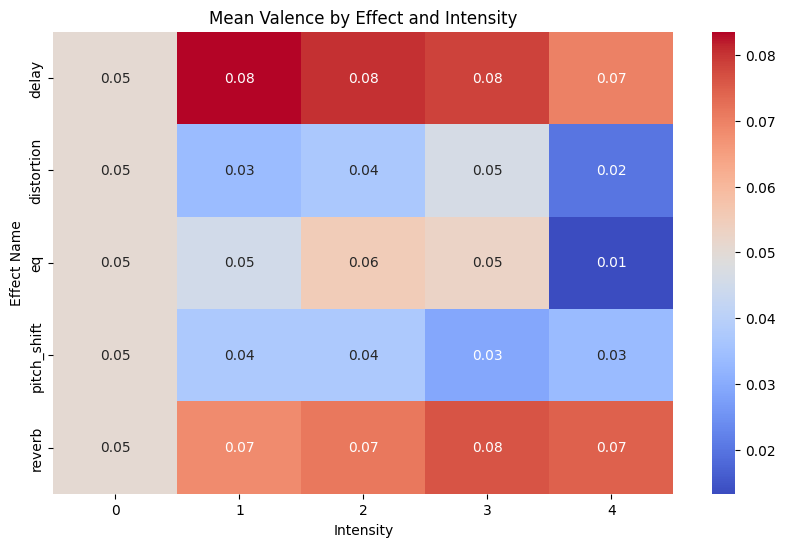

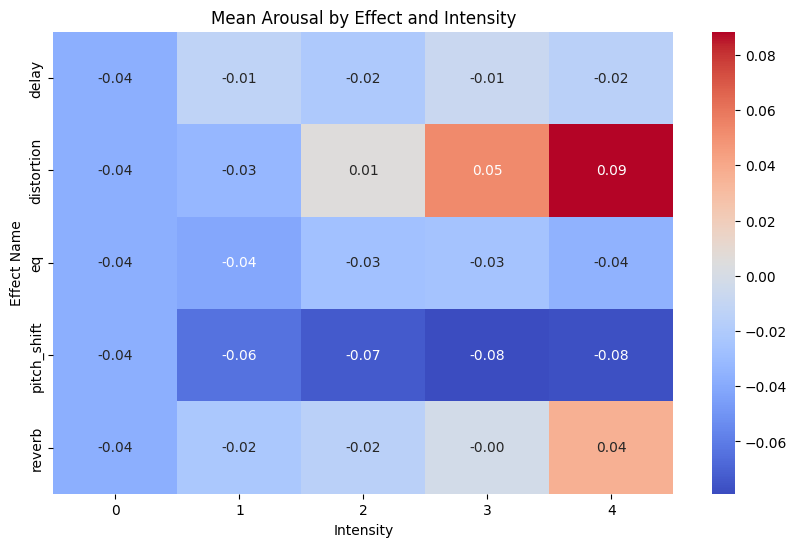

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Use pivot_table instead of pivot for multiple index/column values
heatmap_data = deam_summary.pivot_table(index='effect', columns='intensity', values='mean_valence')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mean Valence by Effect and Intensity')
plt.xlabel('Intensity')
plt.ylabel('Effect Name')
plt.show()

plt.figure(figsize=(10, 6))
# Use pivot_table instead of pivot here as well
heatmap_data = deam_summary.pivot_table(index='effect', columns='intensity', values='mean_arousal')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mean Arousal by Effect and Intensity')
plt.xlabel('Intensity')
plt.ylabel('Effect Name')
plt.show()

We see here that:
1. Distortion shows a strong positive correlation with arousal as intensity increases, with the highest arousal at intensity 4.
2. Pitch shift reduces arousal consistently across all intensities, suggesting a dampening effect on emotional energy.
3. Reverb and EQ have minimal impact on arousal, maintaining close-to-neutral values regardless of intensity.

We then plot the valence and arousal trends in comparison to insensity

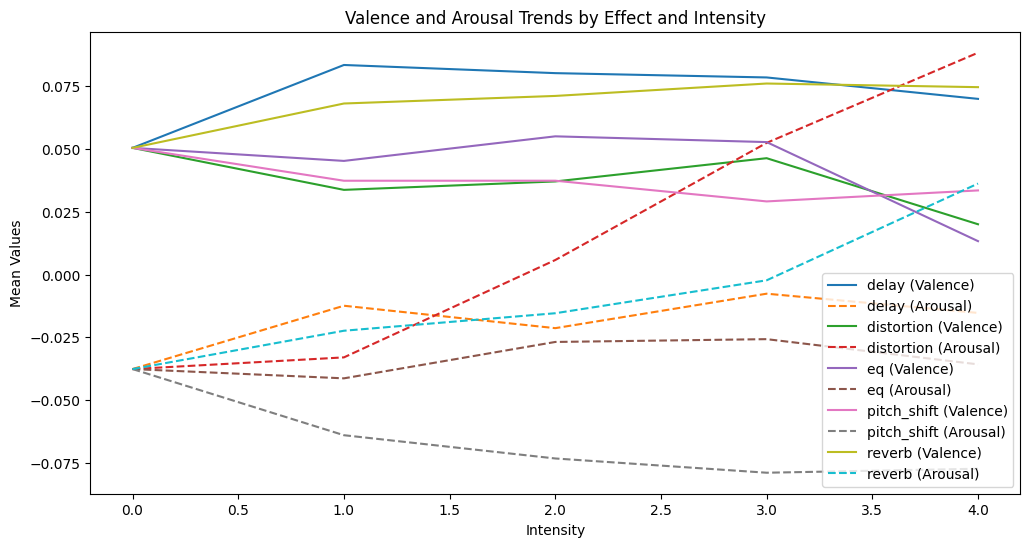

In [335]:
plt.figure(figsize=(12, 6))
for effect in deam_summary['effect'].unique():
    effect_data = deam_summary[deam_summary['effect'] == effect]
    plt.plot(effect_data['intensity'], effect_data['mean_valence'], label=f'{effect} (Valence)')
    plt.plot(effect_data['intensity'], effect_data['mean_arousal'], linestyle='--', label=f'{effect} (Arousal)')

plt.title('Valence and Arousal Trends by Effect and Intensity')
plt.xlabel('Intensity')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

In this chart it is intresting that:
1. Distortion increases both valence and mostly arousal, especially at higher intensities.
2. Reverb maintains a stable valence trend but slightly raises arousal at higher intensities.
3. Pitch shift steadily decreases both valence and arousal, suggesting its tendency to reduce emotional intensity.
4. Delay and EQ have minor effects on both valence and arousal.

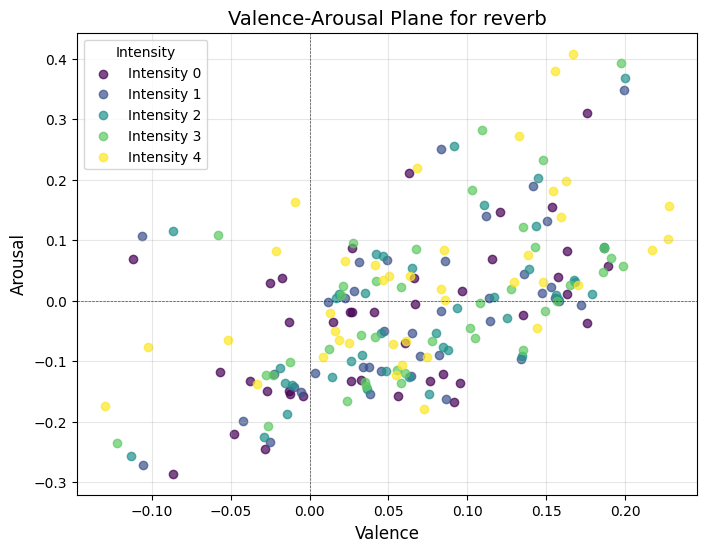

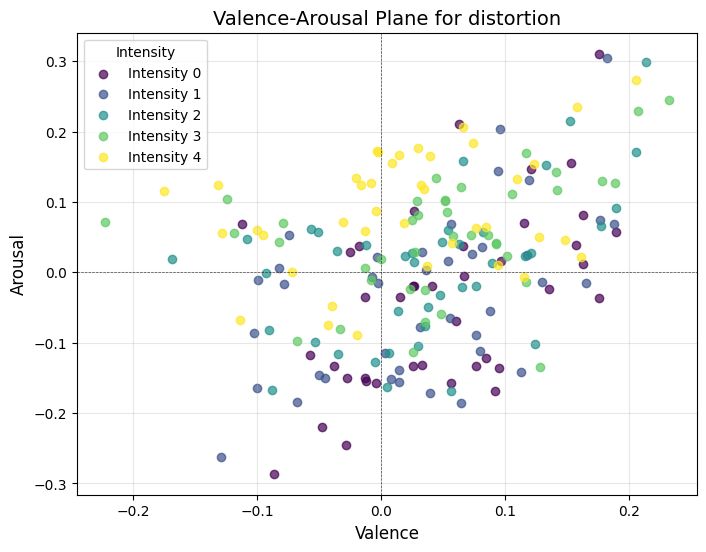

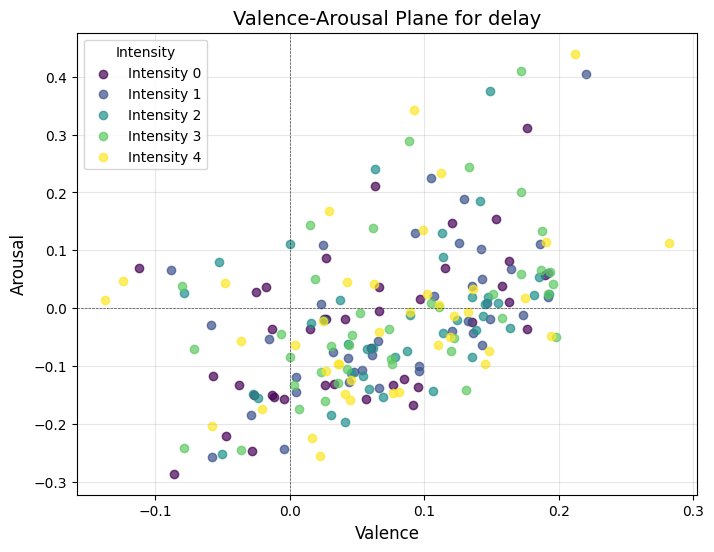

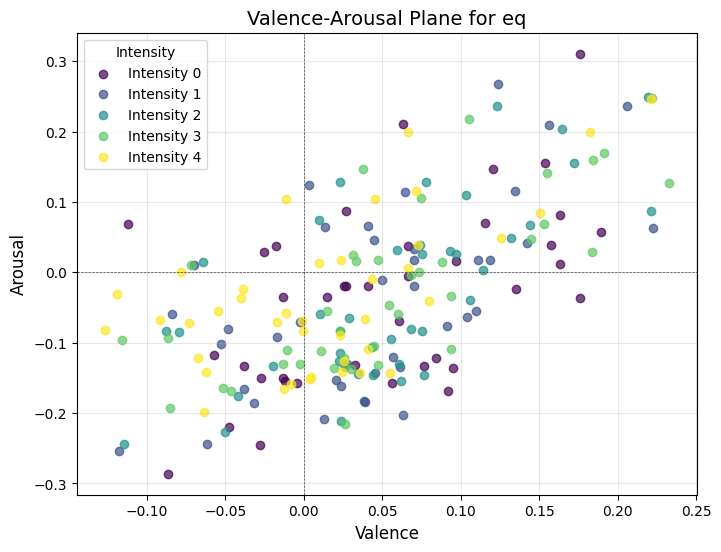

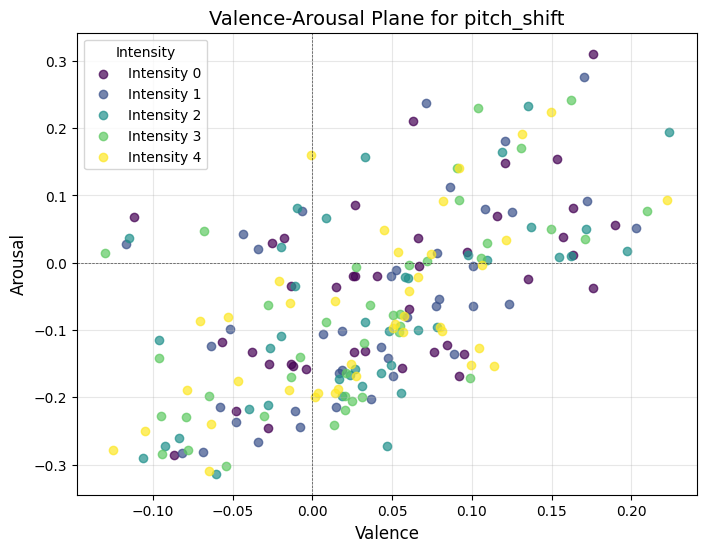

In [346]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define a colormap for intensity levels
colormap = cm.get_cmap('viridis', 5)  # 5 intensity levels (0 to 4)

# Unique effects in the dataset
effects = deam['effect'].unique()

# Plot for each effect
for effect in effects:
    plt.figure(figsize=(8, 6))
    effect_data = deam[deam['effect'] == effect]

    # Scatter plot for each intensity level
    for intensity in sorted(effect_data['intensity'].unique()):
        intensity_data = effect_data[effect_data['intensity'] == intensity]
        color = colormap(intensity / 4)  # Normalize intensity to [0, 1] for colormap
        plt.scatter(
            intensity_data['valence'],
            intensity_data['arousal'],
            label=f'Intensity {intensity}',
            color=color,
            alpha=0.7
        )

    # Plot customization
    plt.title(f'Valence-Arousal Plane for {effect}', fontsize=14)
    plt.xlabel('Valence', fontsize=12)
    plt.ylabel('Arousal', fontsize=12)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.7)
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.7)
    plt.grid(alpha=0.3)
    plt.legend(title='Intensity', fontsize=10)
    plt.show()

In this plot we are excited to observe that:
1. Points are widely dispersed, suggesting that reverb can influence both valence and arousal variably depending on the song and intensity.
2. Higher intensity points (e.g., yellow) tend to cluster slightly toward higher arousal but are still scattered across the valence dimension.

####Classification Plots

For classification plotting we first use the stacked bar chart of label proportions

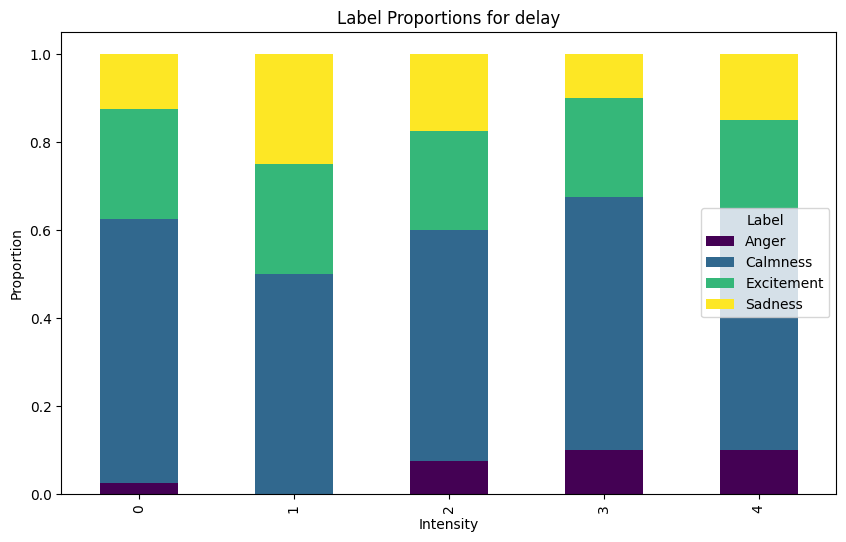

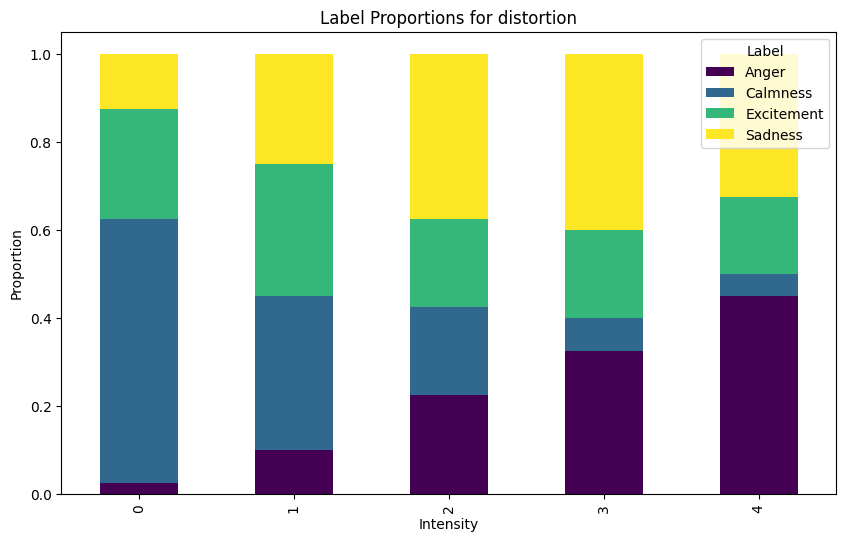

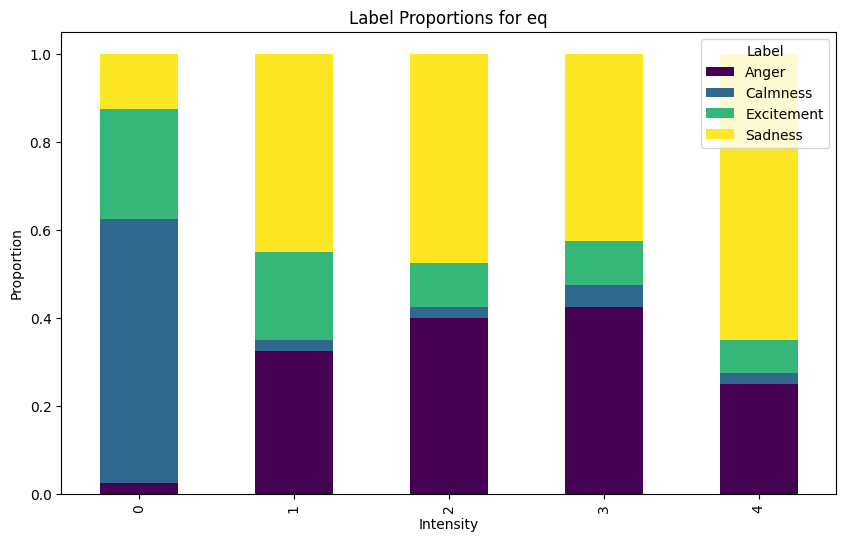

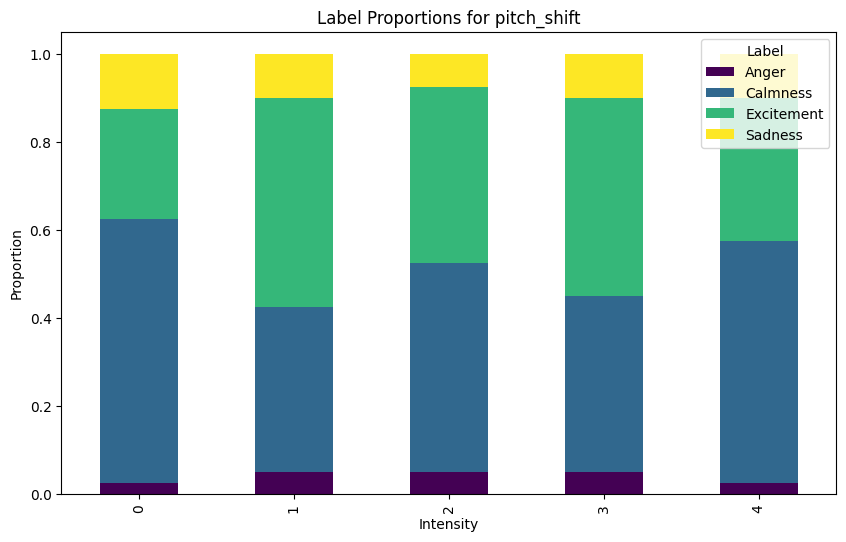

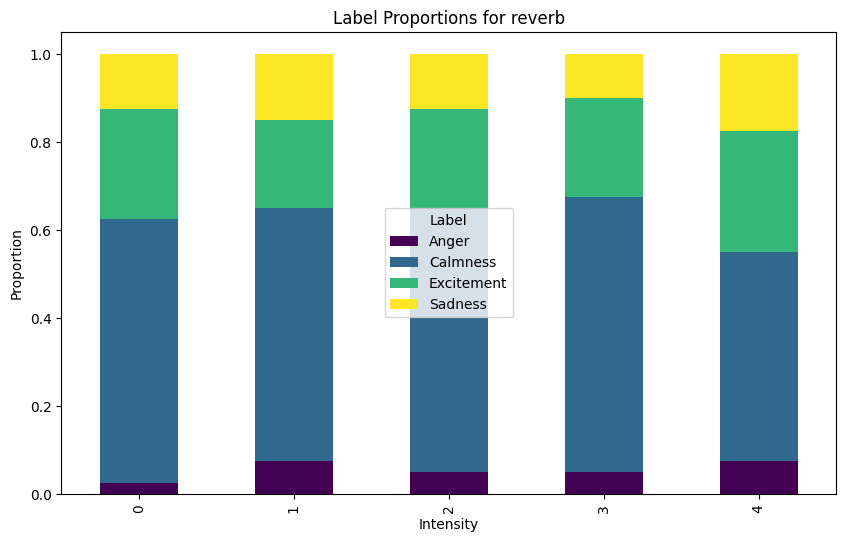

In [337]:
effect_list = emopia_pivot_normalized.index.get_level_values('effect').unique()

for effect in effect_list:
    data = emopia_pivot_normalized.loc[effect]
    data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title(f'Label Proportions for {effect}')
    plt.xlabel('Intensity')
    plt.ylabel('Proportion')
    plt.legend(title='Label')
    plt.show()


In this chart it is clear that:
1. Pitch shift increases calmness proportionally as intensity rises.
2. Excitement decreases with intensity, aligning with the arousal trend from the previous plots.
3. Sadness and anger remain relatively unaffected across intensities.

We also use a radar chart

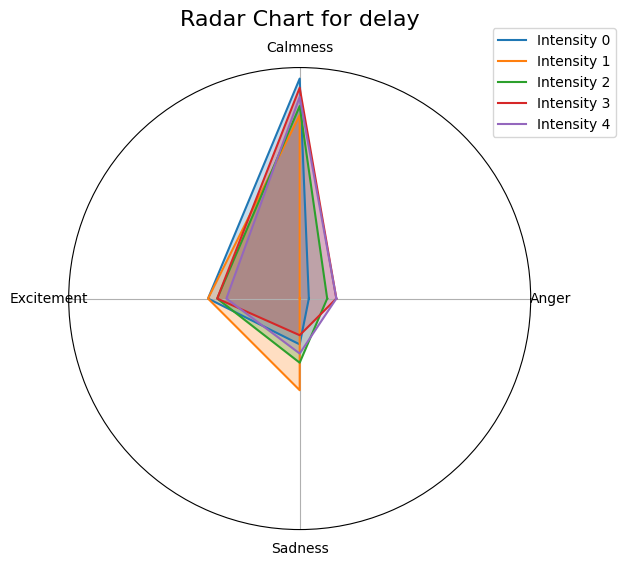

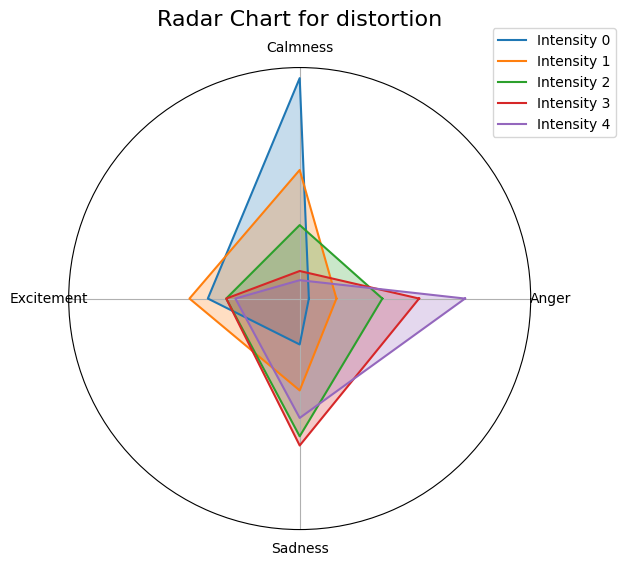

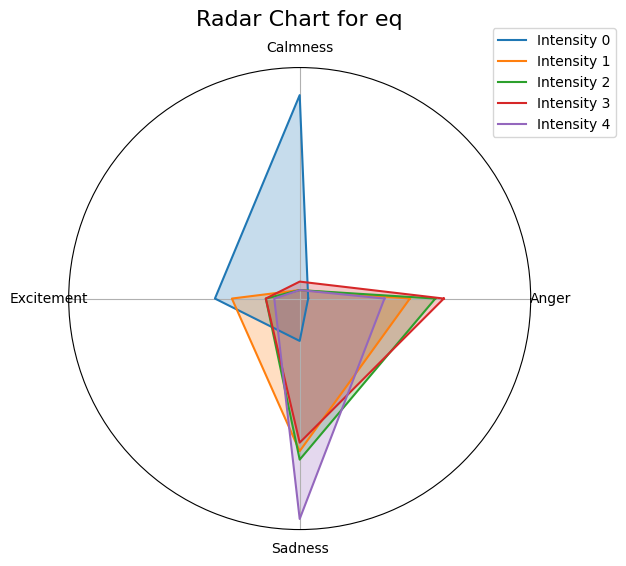

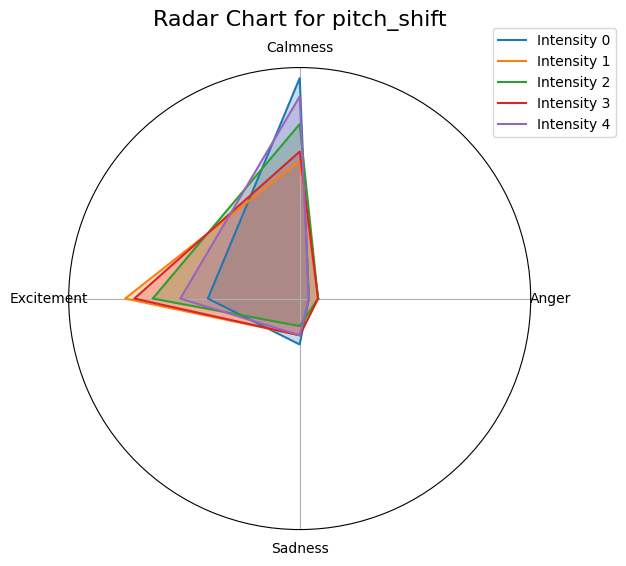

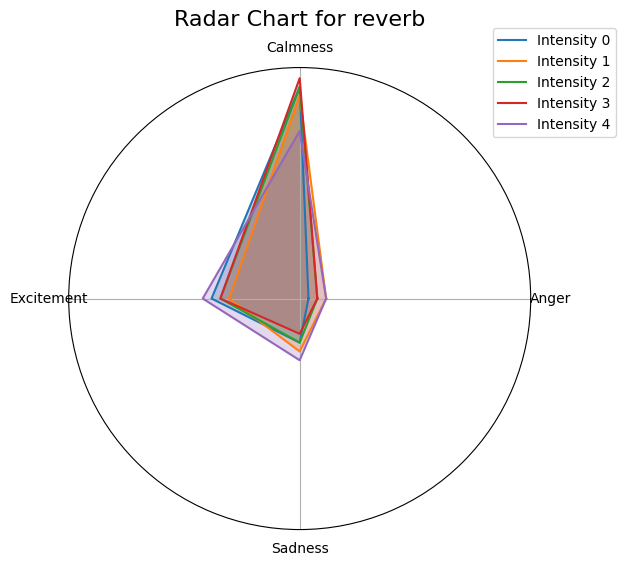

In [347]:
from math import pi

def radar_chart(data, title):
    labels = data.columns
    num_vars = len(labels)

    # Create angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for idx, row in data.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Intensity {idx}')
        ax.fill(angles, values, alpha=0.25)

    # Adjust title position with pad
    ax.set_title(title, size=16, pad=30)  # Increase pad value to move the title up
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()

# Plot for each effect
for effect in emopia_pivot_normalized.index.get_level_values('effect').unique():
    radar_chart(emopia_pivot_normalized.loc[effect], f'Radar Chart for {effect}')


Here we observe:
1. Excitement is dominant at lower intensities but reduces significantly at higher intensities.
2. Calmness grows steadily as pitch shift intensity increases.
3. Sadness and anger remain stable and less prominent across all intensities.

####Correlation Analysis

We apply correlation analysis for regression, as well as for classification

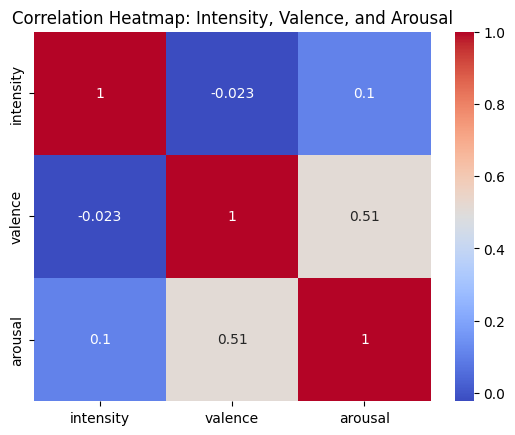

In [340]:
# Correlation of intensity with valence and arousal
correlation = deam[['intensity', 'valence', 'arousal']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Intensity, Valence, and Arousal')
plt.show()


Lastly we can point out the fact that intensity has a weak but positive correlation with arousal (0.1), indicating a slight tendency for higher intensities to increase arousal.

In [344]:
# Chi-square test for association between effect intensity and labels
from scipy.stats import chi2_contingency

for effect in emopia['effect'].unique():
    contingency_table = pd.crosstab(emopia[emopia['effect'] == effect]['intensity'],
                                    emopia[emopia['effect'] == effect]['results'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'{effect}: Chi-square = {chi2:.2f}, p-value = {p:.4f}')


reverb: Chi-square = 3.75, p-value = 0.9876
distortion: Chi-square = 61.36, p-value = 0.0000
delay: Chi-square = 9.57, p-value = 0.6535
eq: Chi-square = 105.88, p-value = 0.0000
pitch_shift: Chi-square = 7.92, p-value = 0.7915


For the chi-square test we can conclude that:
1. Reverb: Not significant (p = 0.9876) – reverb intensity does not significantly affect emotional labels.
2. Distortion: Significant (p = 0.0000) – distortion intensity strongly influences emotional labels, evoking clear emotional changes.
3. Delay: Not significant (p = 0.6535) – delay intensity has little impact on emotional labels.
4. EQ: Significant (p = 0.0000) – EQ intensity significantly alters emotional labels, making it an effective tool for emotional manipulation.
5. Pitch Shift: Not significant (p = 0.7915) – pitch shift intensity has limited effect on emotional labels.